# Experiment 2: Do V20 lake fields + some extra surface fields improve our predicitions?

We compare two models:

* A model using time variable features + `cl_v15,lsm_v15,dl_v15,cvl_v15,cvh_v15`
* A model using time variable features + `cl_v15,lsm_v15,dl_v15,cvl_v15,cvh_v15` + V20 corrections for all the `*_v15` fields

The correction is obtained by calculating e.g. `cl_V20 - cl_V15`.

---


# A. How do these surface fields change going from V15 to V20?

Before looking at the model results, it is worth having a quick look at how the surface field parameters are updated when we go from V15 to V20. See also `A1.V20_vs_V15.ipynb` in this directory.



In [2]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




def correct_longitude(ds):    
    return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    

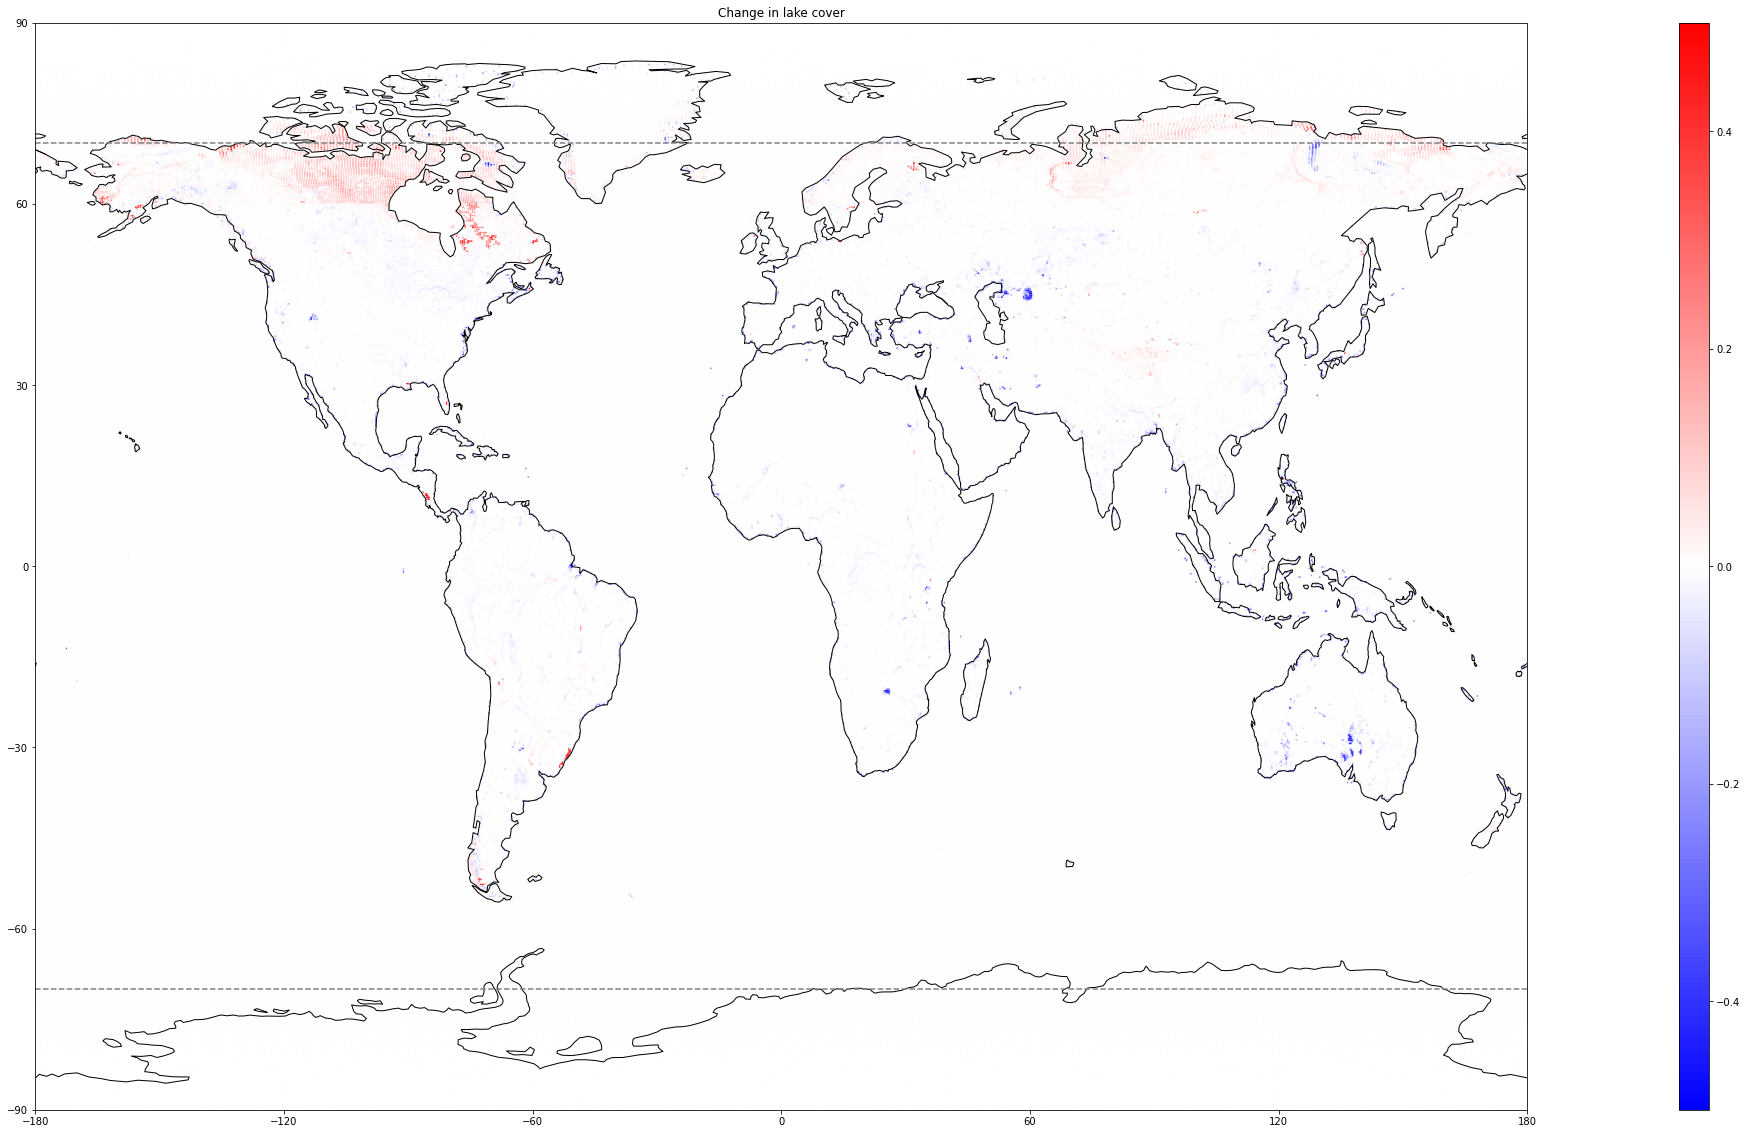

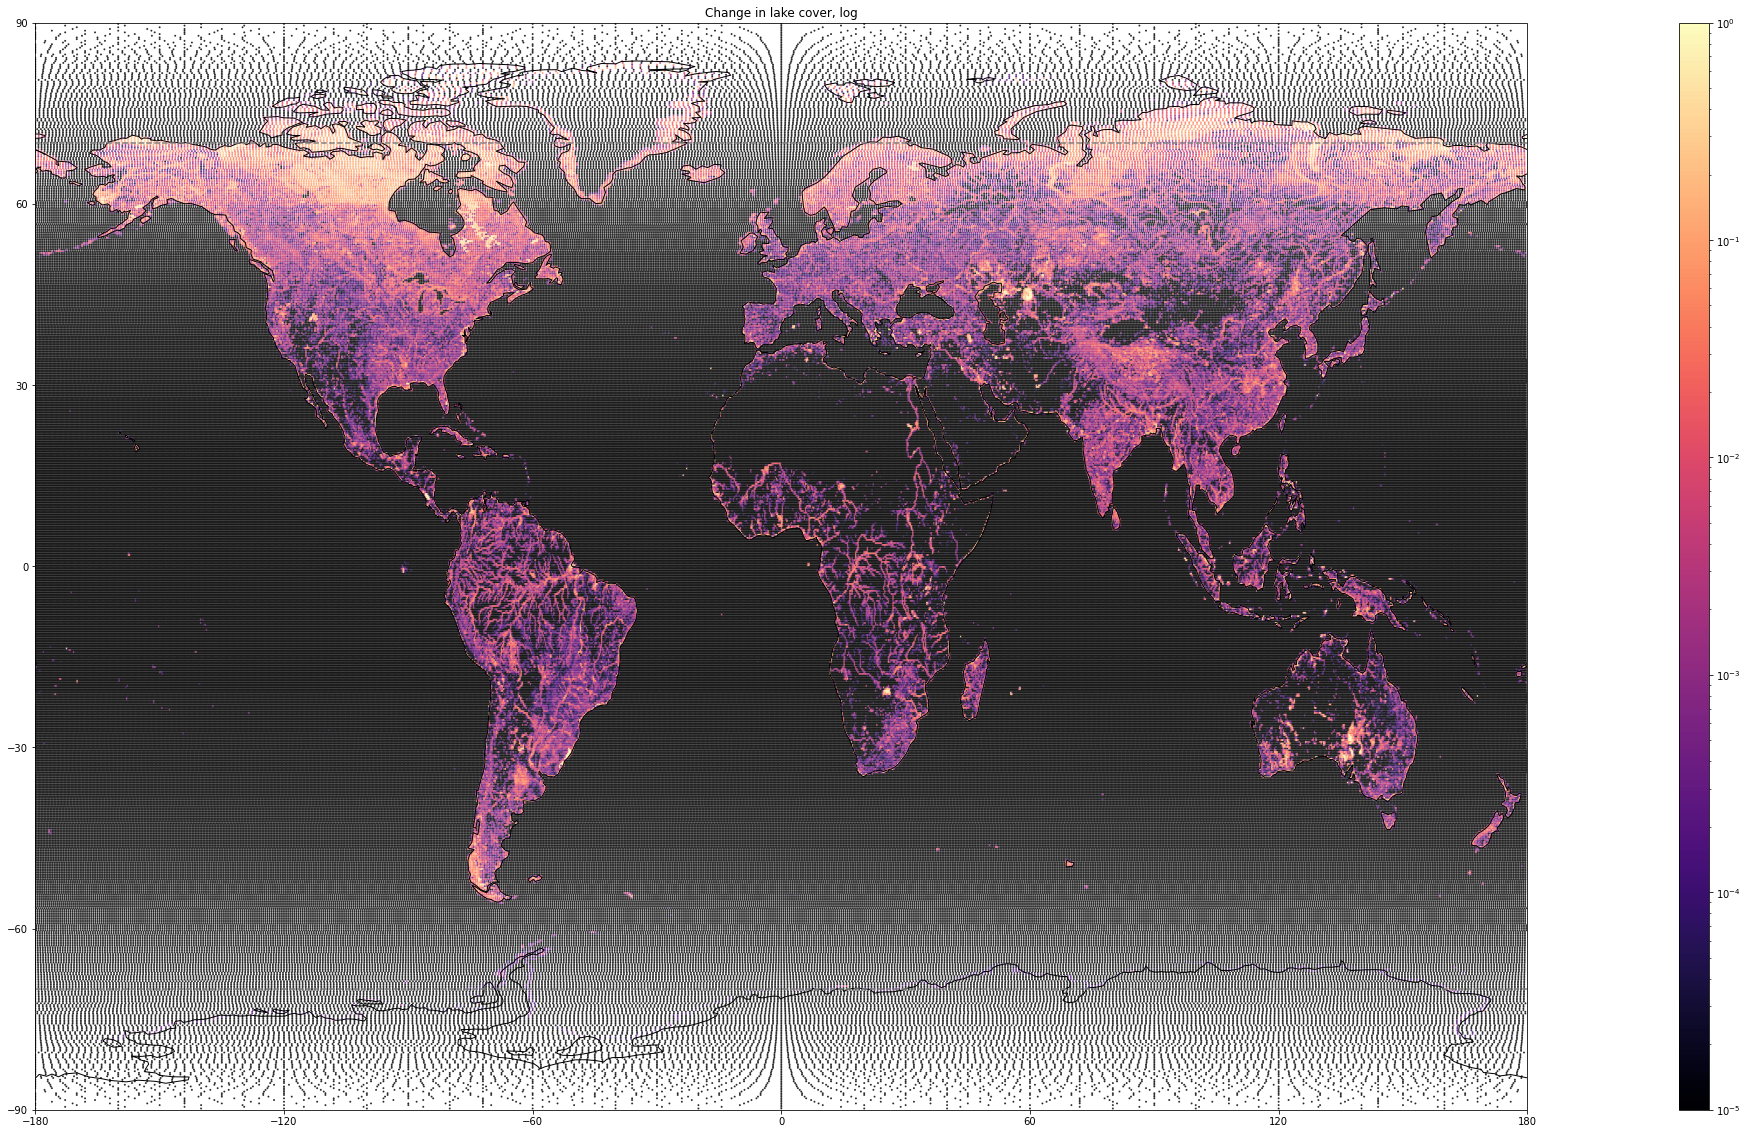

In [4]:

#Setup
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']



ds = [] #Array to hold results
for v in version:
    clake_path = root+f'climate.{v}/climate.{v}/639l_2/clake'
    ds_i= xr.open_dataset(clake_path,engine='cfgrib',backend_kwargs={'indexpath': ''}) 
    ds.append(ds_i)

#Take the difference    
delta = ds[1] - ds[0] #V20 - V15
delta = correct_longitude(delta) #long3 ---> long1

#Plot it
# limits = {'xlow': -72,
#            'xhigh':-70,
#            'ylow':6,
#            'yhigh':15}

limits = None

plot_map(delta,'cl',vmin=-0.5,vmax=+0.5,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover',limits=limits,markersize=1)

#We can also blow up the scale:
plot_map(delta,'cl',vmin=1e-5,vmax=1,cmap=plt.cm.magma,logscale=True,title='Change in lake cover, log',limits=limits,markersize=1)


We can see that the siginificant modifications to the lake cover happen in a few key areas.


---

# B. How does this extra information influence the model?


Ok we now have seen how the `cl` feature is changing. If we pass this extra information to the model, does it improve our predictions?

In [9]:
import pandas as pd
import json
import numpy as np

def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs):
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)

        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        

        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        try:
            validation_loss = d['val_loss'][i:]
            plt.plot(epochs,validation_loss, label='validation loss')
        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')


input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V2.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 10000
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'cl_v15', 'lsm_v15', 'dl_v15', 'cvl_v15', 'cvh_v15']
 optimizer: adam

input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V2.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 10000
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'cl_v15', 'lsm_v15', 'dl_v15', 'cvl_v15', 'cvh_v15', 'cl_delta', 'lsm_delta', 'dl_delta', 'cvh_delta', 'cvl_delta']
 optimizer: adam



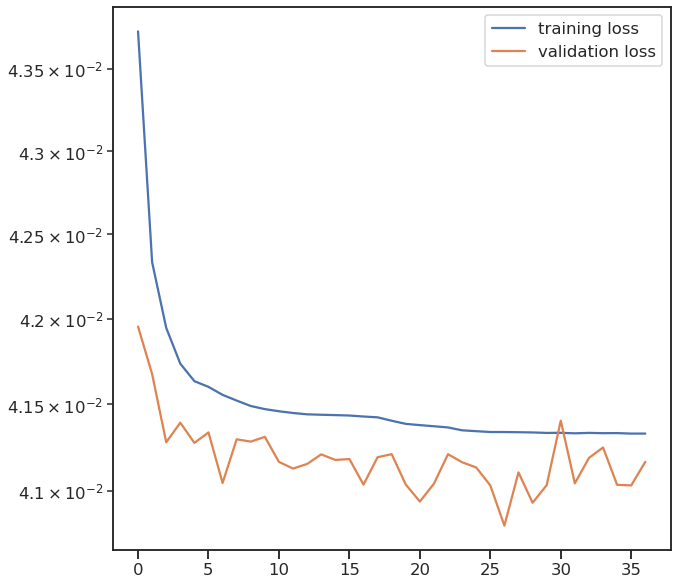

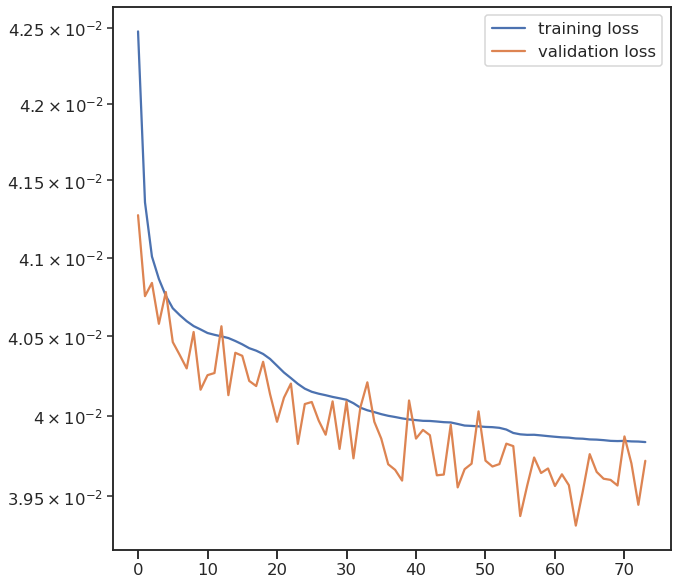

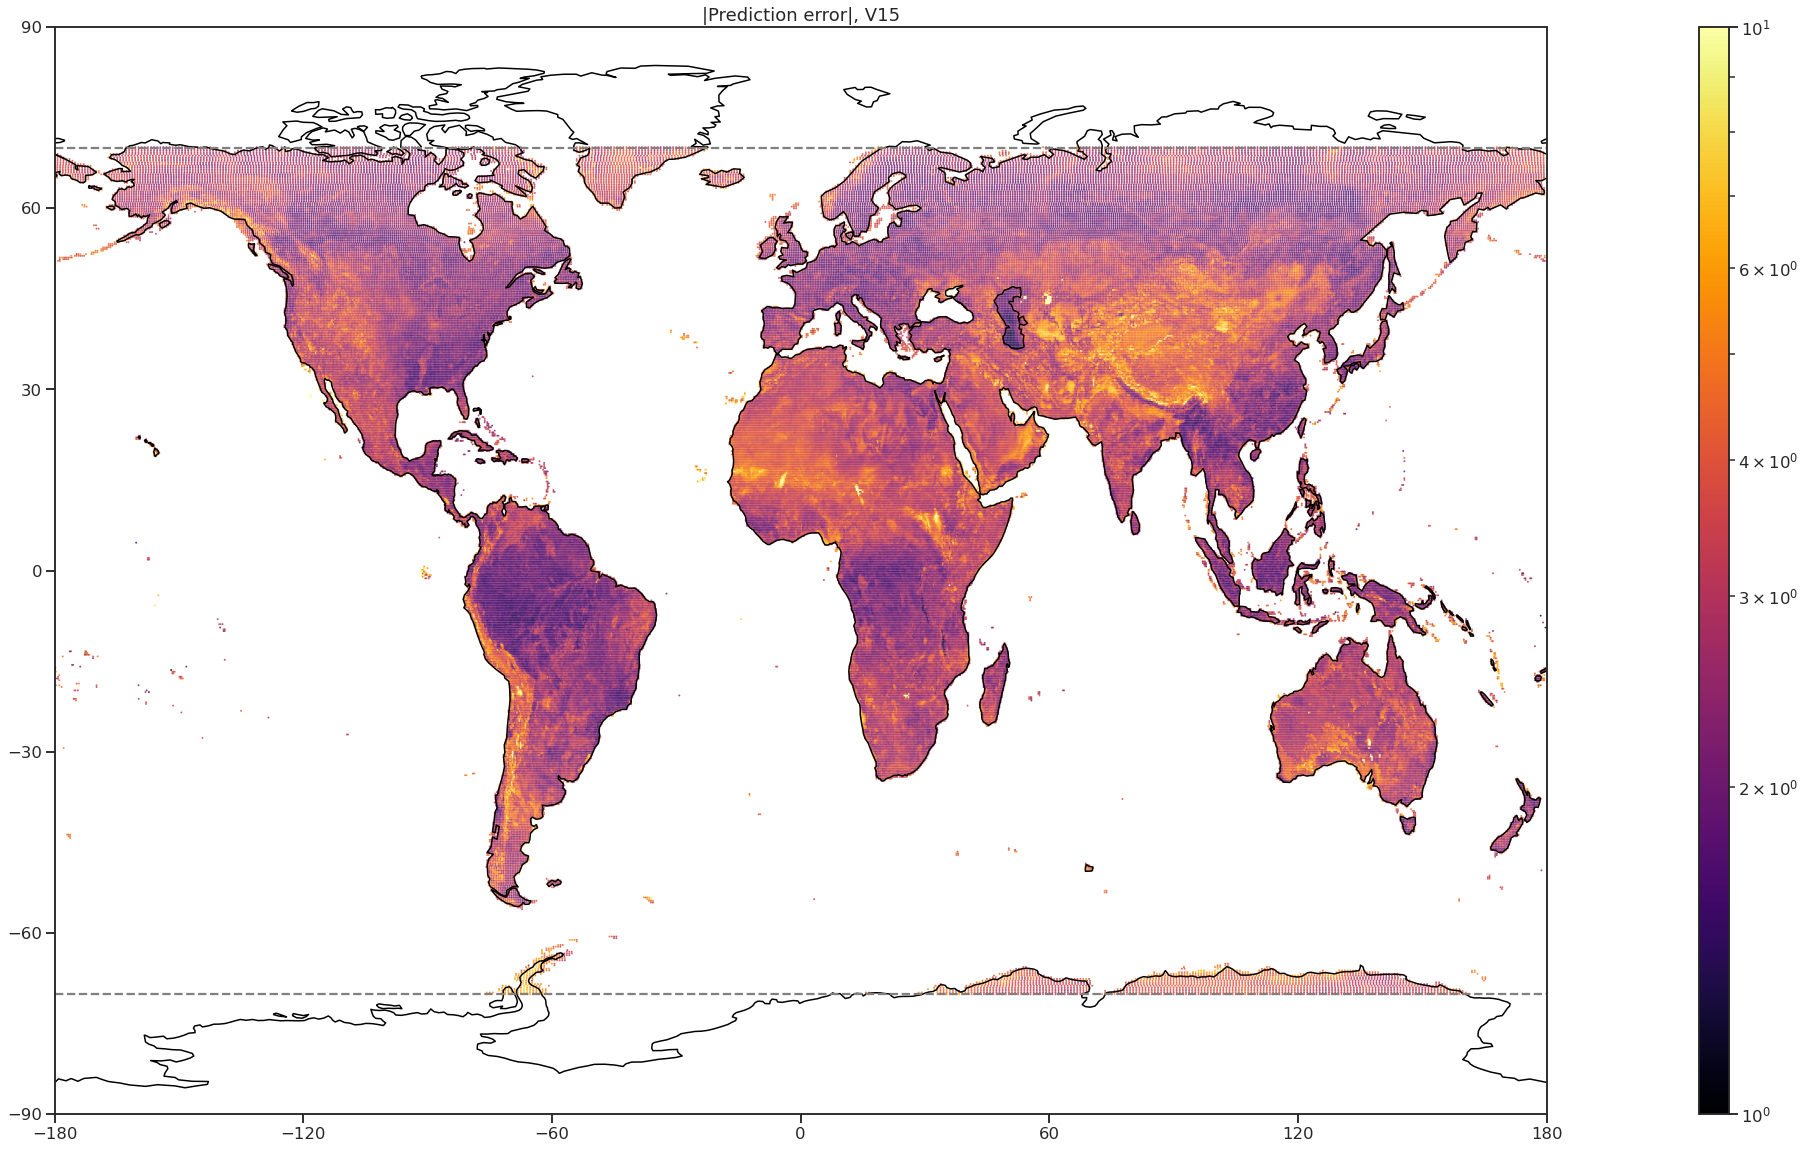

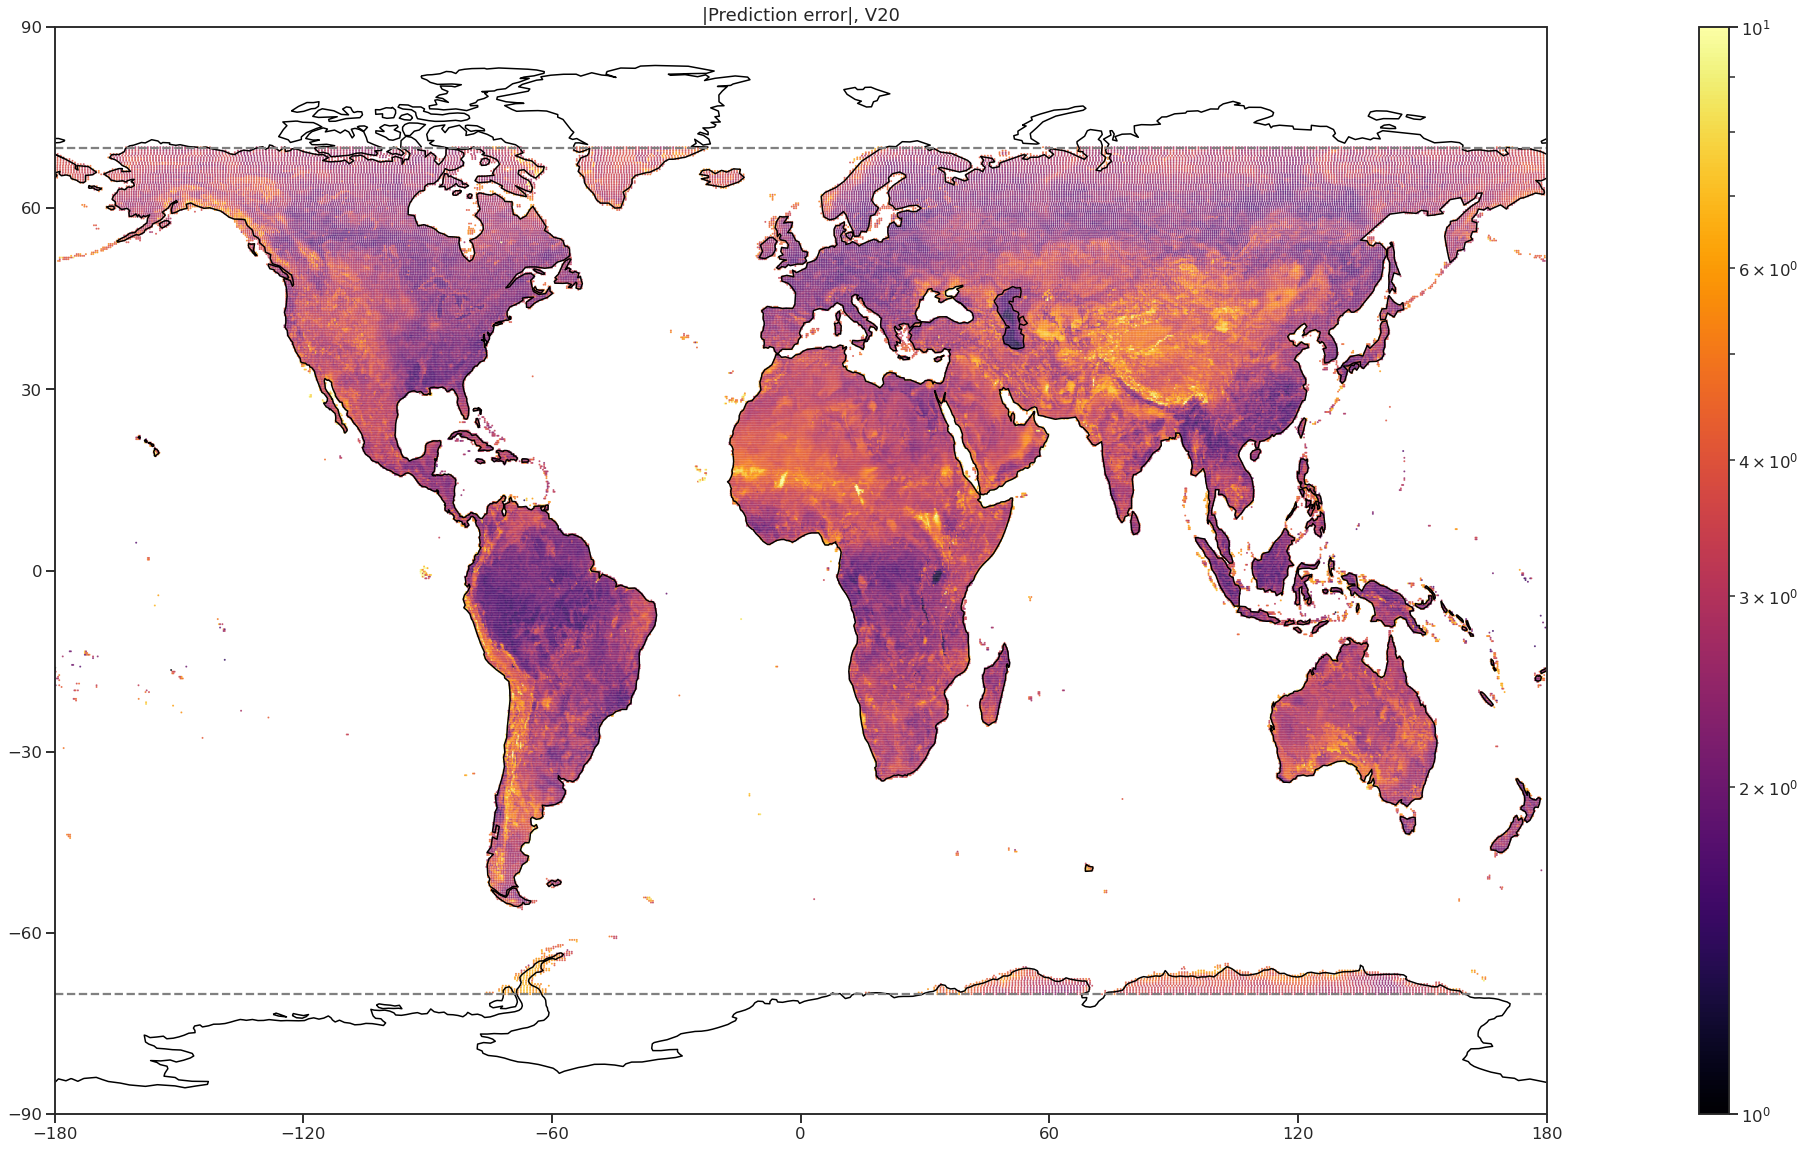

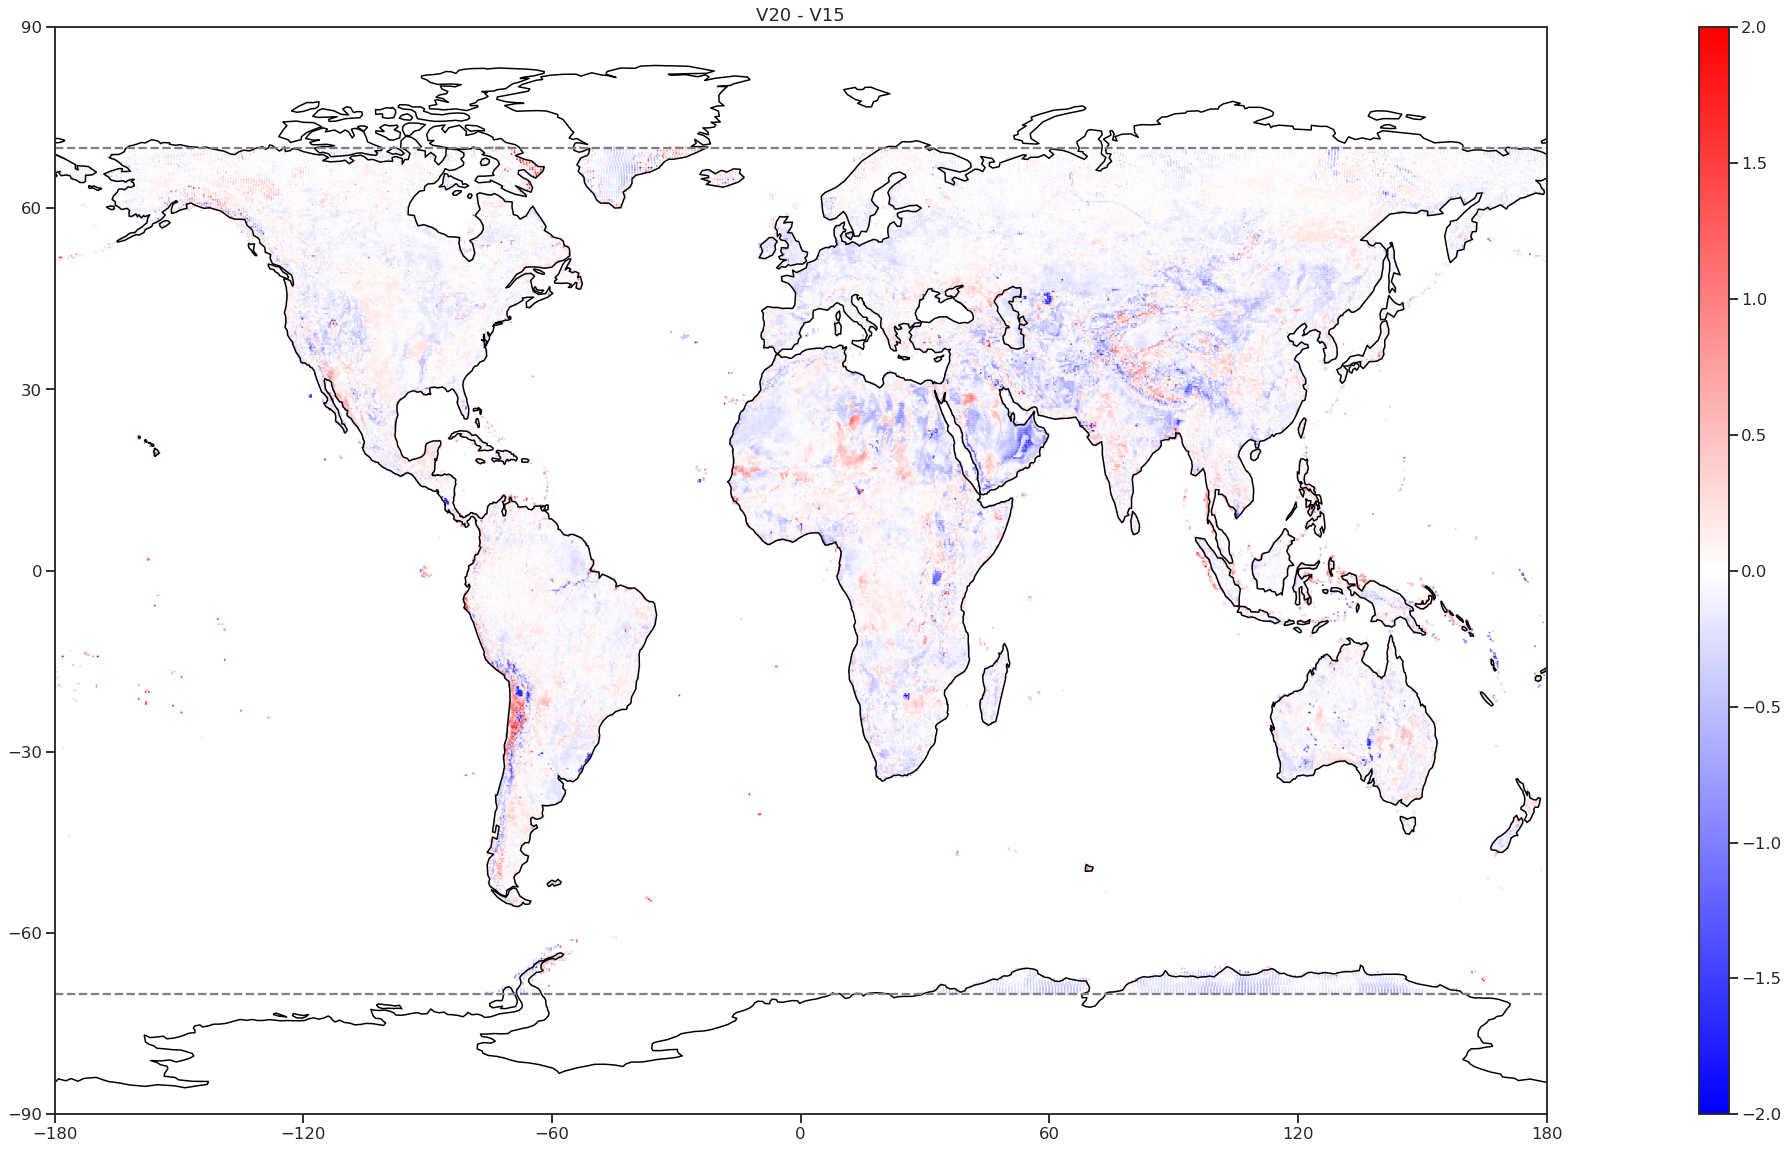

In [10]:


#Parameters
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
modelV15 = 'ML_fb0416bcbcf943e0bcd57f9bc5d3a70c/' 
modelV20 = 'ML_9d2f648ad7e844b79d64a08fd3793121/' 
#modelV20 = 'ML_f311109a3b7d4fac827948721844a760/' #moer patience
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process 
V15 = load_predictions(models_root+modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year


V20 = load_predictions(models_root+modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    
    
    
#Plot training history for interest
plot_training_history(models_root+modelV15,logscale=True,jump_n_epochs=1) 
plot_training_history(models_root+modelV20,logscale=True,jump_n_epochs=1)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_grouped.latitude_ERA, 
        'longitude_ERA':  V20_grouped.longitude_ERA,
        'MODIS_LST':      V20_grouped.MODIS_LST,
        'V15_prediction': V15_grouped.predictions,
        'V20_prediction': V20_grouped.predictions,
        'V15_error':      V15_grouped.absolute_model_error,
        'V20_error':      V20_grouped.absolute_model_error,
        'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
df_delta = pd.DataFrame(data)    
plot_map(df_delta,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)

    
    




# B1 Apply a mask




From this map it is hard to disentangle regions of improvement over the inherent variability due to the stochasticity of training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**

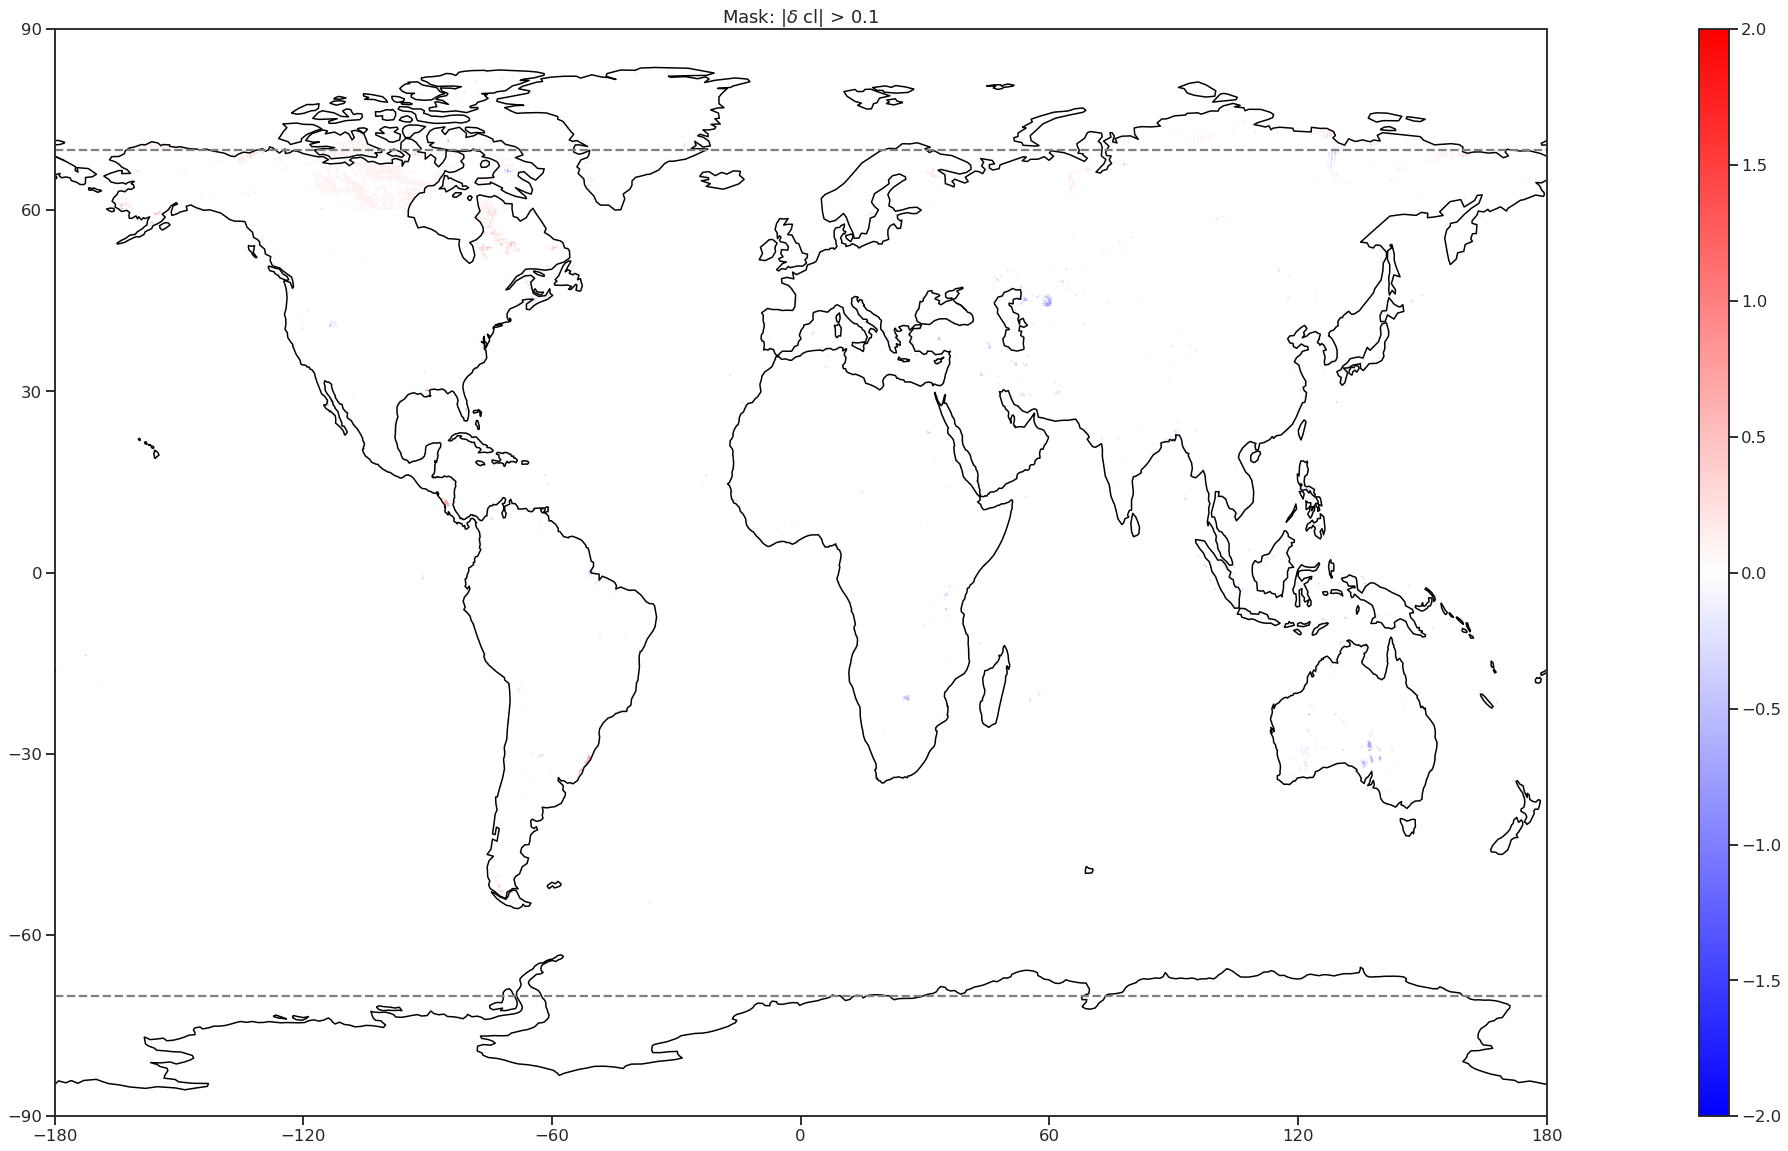

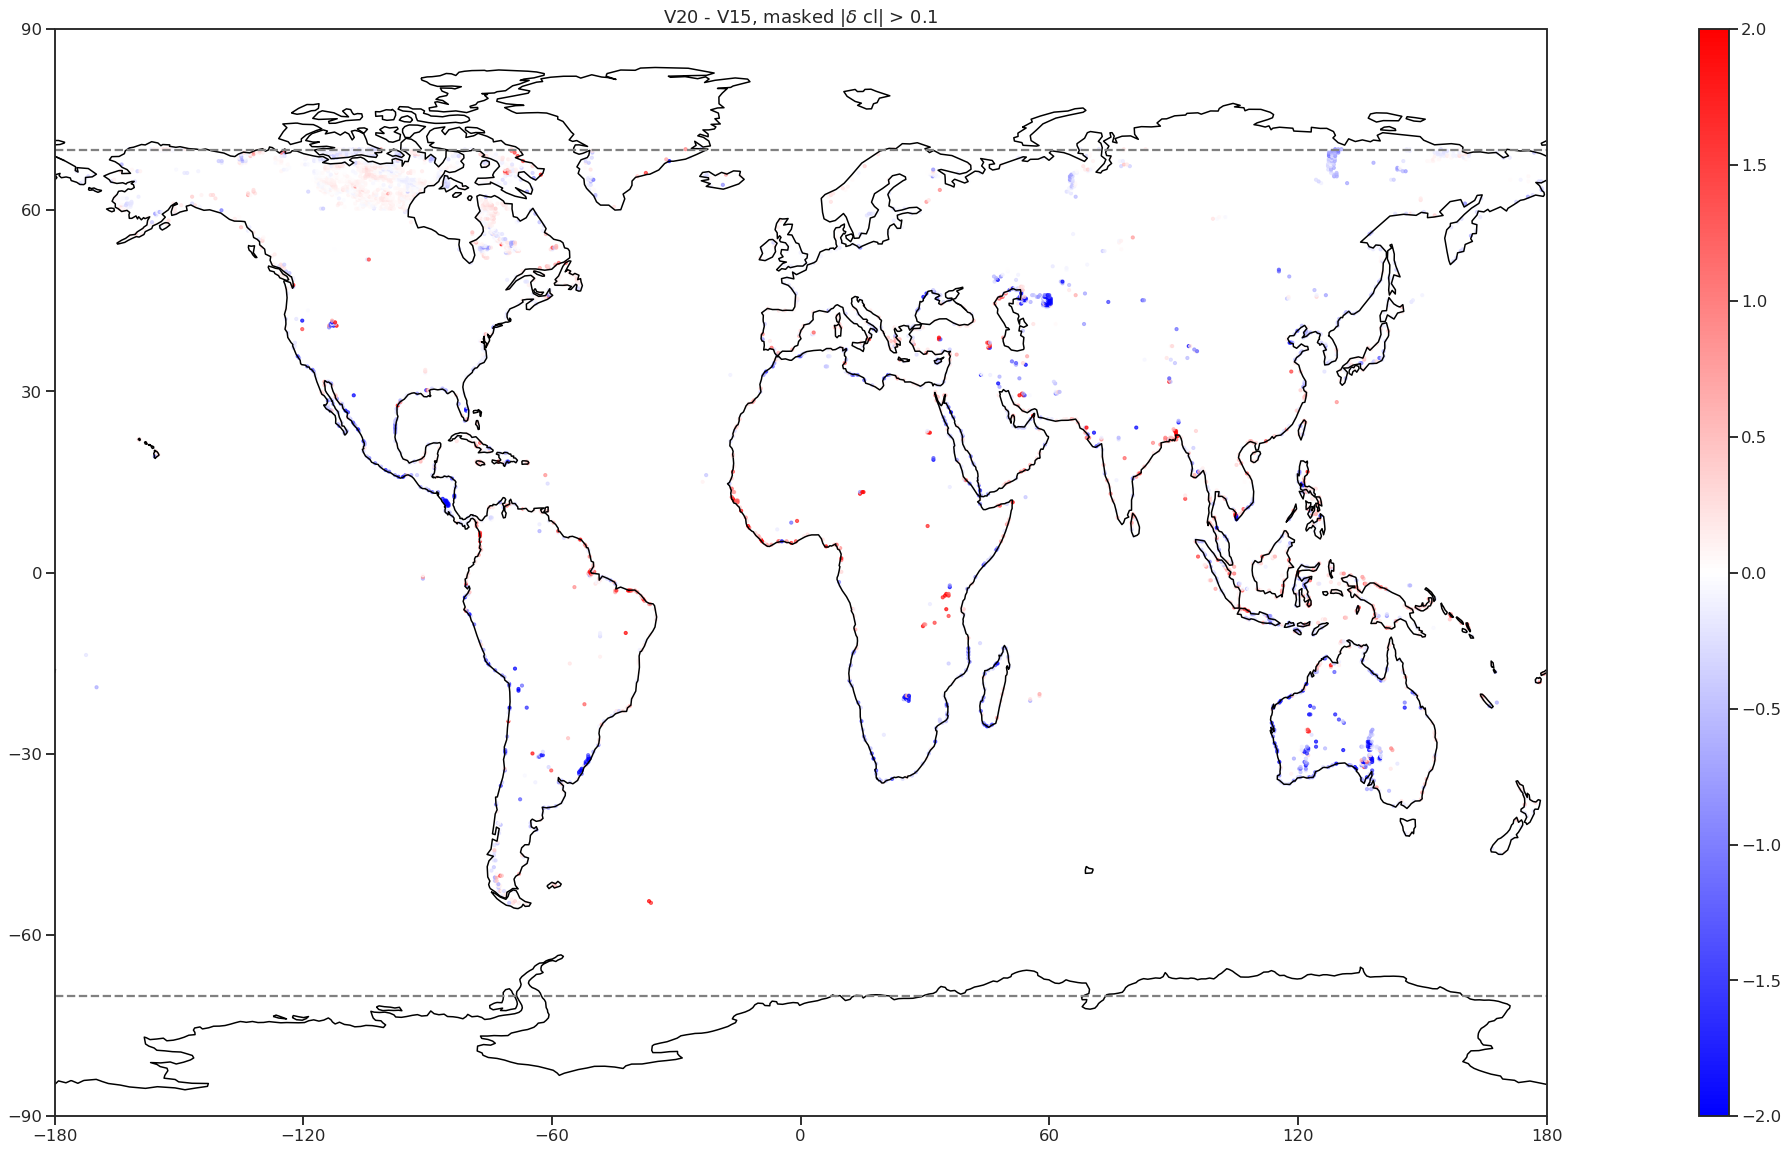

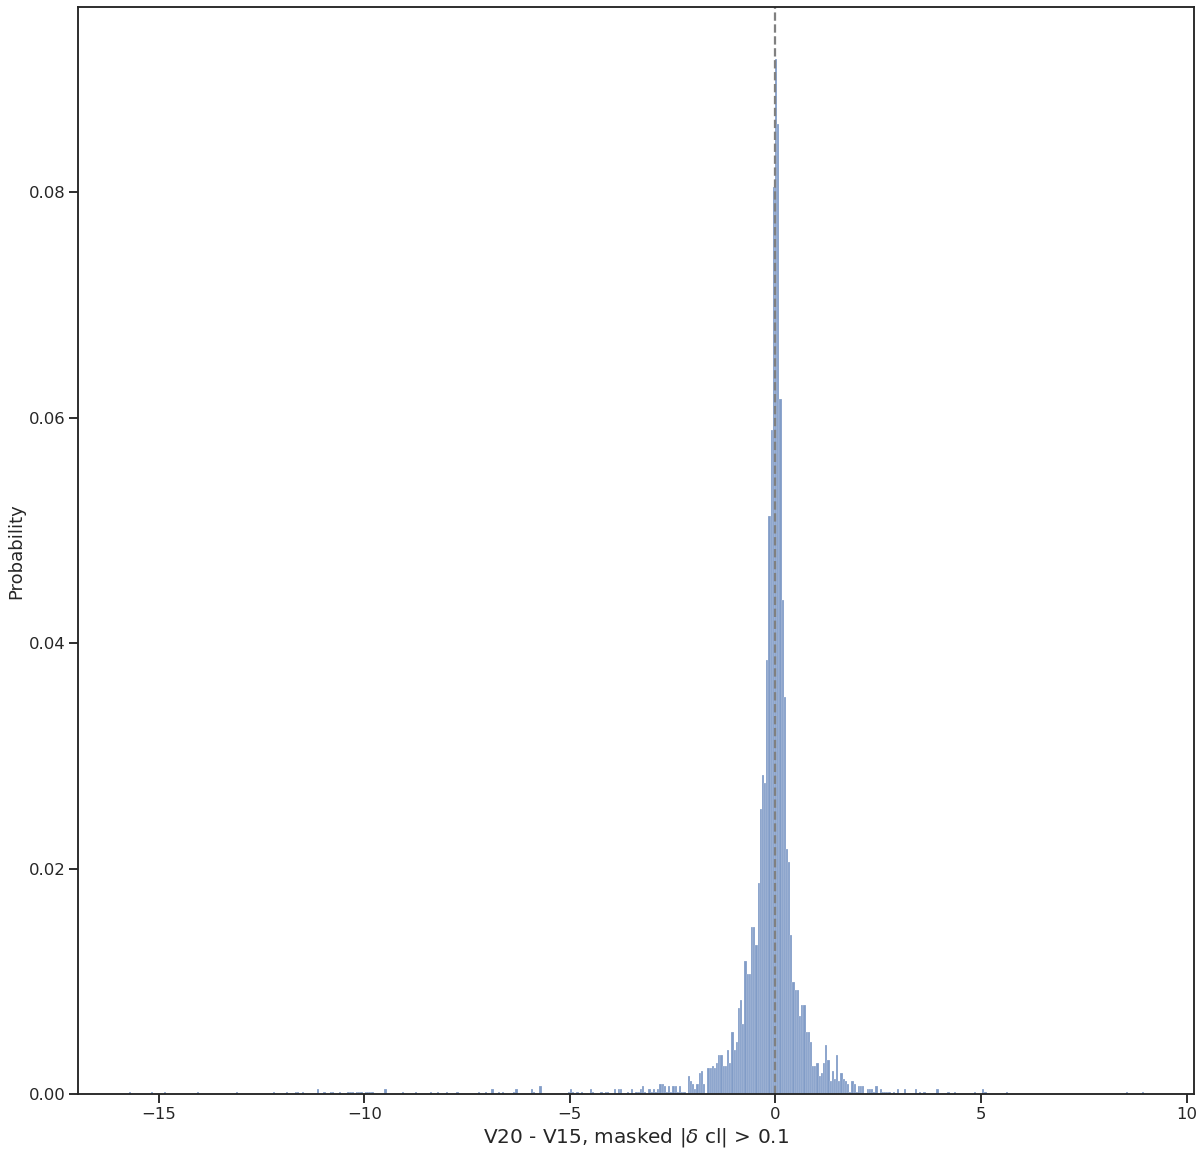

Mean Improvement = -0.17483099
Num samples = 4314
Max improvement =  -15.720214


In [11]:

#Create a mask and plot it
mask = delta.to_dataframe().reset_index() #delta is V20 cl - V15 cl that we defined in section A
p = 0.1 # cutoff paramter
mask = mask[abs(mask.cl) > p] #Only get the points where cl changed by > 0.3. What is a reasonable value for this variable?
plot_map(mask,'cl',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=1) #What does this mask look like?

#Apply mask to df_delta
df_delta_masked = pd.merge(df_delta,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude'])
plot_map(df_delta_masked,'delta',
         vmin=-2,vmax=+2,
         cmap=plt.cm.bwr,
         logscale=False,
         title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
         limits=None,
         markersize=10)


#Plot distribution of improvements
import seaborn as sns


#Setup plot env
h,w = 20,20
sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )
#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
sns.histplot(df_delta_masked['delta'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')


# Config
ax1.set_xlabel(f'V20 - V15, masked |${{\delta}}$ cl| > {p}', fontsize = 20)

ax1.axvline(0,c='0.5', linestyle='--')
plt.show()



#Surface some numbers

print('Mean Improvement =', df_delta_masked.delta.mean())
print ('Num samples =',  len(df_delta_masked))
print ('Max improvement = ',df_delta_masked.delta.min() )



In [12]:
display(df_delta_masked.sort_values(by=['delta'],ascending=False).head(20))

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
865      -3.512879      35.156250  301.797272      301.215057      312.696106   
792      -6.042153      35.156250  305.171234      302.833801      316.468719   
857      -3.793910      34.875000  305.867157      306.725952      314.053711   
2788     54.379367     -72.187500  270.896057      273.900299      261.777618   
1023      0.140515     -50.625000  299.526062      302.756317      307.929779   
1015     -0.140515     -50.625000  300.542664      303.356567      308.488953   
1022      0.140515     -50.906250  301.339539      302.698303      308.641052   
1893     29.367672      53.750000  306.283661      306.881317      312.697388   
1375     13.067912      14.343750  300.484894      303.243561      307.683319   
1902     29.648702      53.437500  307.886749      307.086700      313.904602   
665      -9.976578     -42.187500  303.127777      307.062805      311.149597   
1892     29.367672      52.812500  306.122681      308.015808      312.314026   
1959     31.615914      88.960000  284.477783      285.991425      278.293304   
2193     38.079612      45.333333  291.615021      291.466309      297.561188   
2331     41.451975    -112.320000  295.985901      297.805573      302.314240   
1750     24.028095      69.000000  313.644440      303.138489      299.991058   
1716     23.185004      31.200000  311.227936      315.518494      318.719330   
888      -2.950819     -41.343750  303.930237      307.192230      310.319519   
1142      5.199062      -9.281250  298.925903      302.088684      305.156342   
2298     40.889915    -111.960000  297.192566      298.433563      302.780609   

      V15_error  V20_error     delta  values   step  surface   latitude  \
865    1.942433  10.898833  8.956400  286525 0 days      0.0  -3.512879   
792    2.764847  11.297493  8.532646  298045 0 days      0.0  -6.042153   
857    2.534619   8.192524  5.657906  287804 0 days      0.0  -3.793910   
2788   4.131008   9.252876  5.121868   52171 0 days      0.0  54.379367   
1023   3.324917   8.403712  5.078795  270860 0 days      0.0   0.140515   
1015   2.901267   7.946290  5.045022  272140 0 days      0.0  -0.140515   
1022   2.445054   7.301496  4.856441  270859 0 days      0.0   0.140515   
1893   2.068503   6.413722  4.345218  139475 0 days      0.0  29.367672   
1375   3.012808   7.198430  4.185622  210931 0 days      0.0  13.067912   
1902   2.056443   6.018442  3.961999  138322 0 days      0.0  29.648702   
665    4.140851   8.056483  3.915632  316970 0 days      0.0  -9.976578   
1892   2.556520   6.200523  3.644003  139472 0 days      0.0  29.367672   
1959   3.078899   6.570055  3.491156  130500 0 days      0.0  31.615914   
2193   2.629681   6.046658  3.416977  105113 0 days      0.0  38.079612   
2331   3.037817   6.431297  3.393481   93521 0 days      0.0  41.451975   
1750  10.514669  13.653387  3.138718  162045 0 days      0.0  24.028095   
1716   4.383407   7.505180  3.121773  165519 0 days      0.0  23.185004   
888    3.418516   6.417758  2.999242  284973 0 days      0.0  -2.950819   
1142   3.232810   6.230427  2.997617  247967 0 days      0.0   5.199062   
2298   2.939669   5.819212  2.879543   95522 0 days      0.0  40.889915   

       longitude        cl  
865    35.156250 -0.638541  
792    35.156250 -0.727888  
857    34.875000 -0.402907  
2788  -72.187500  0.731721  
1023  -50.625000 -0.603153  
1015  -50.625000 -0.588097  
1022  -50.906250 -0.604843  
1893   53.750000 -0.265700  
1375   14.343750 -0.163499  
1902   53.437500 -0.348912  
665   -42.187500 -0.154305  
1892   52.812500 -0.222259  
1959   88.960000  0.116714  
2193   45.333333 -0.267091  
2331 -112.320000 -0.267667  
1750   69.000000  0.121381  
1716   31.200000 -0.371459  
888   -41.343750 -0.322522  
1142   -9.281250 -0.391908  
2298 -111.960000 -0.222562

Note:
* Blues = good. This means that the error in V15 is greater than the error in V20.

# Comparison

In [13]:
df_old = pd.read_pickle("NB1_df_delta_masked_0.1.pkl")

In [14]:
df_delta_masked

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
0       -54.941427      -66.56250  279.632904      279.344727      279.722412   
1       -54.660397      -70.31250  273.235840      275.395050      272.170135   
2       -54.660397      -69.37500  274.200592      272.413330      270.281586   
3       -54.660397      -67.96875  278.237396      276.537415      276.613220   
4       -54.660397      -66.09375  279.883881      279.974304      280.424561   
...            ...            ...         ...             ...             ...   
4309     70.117048      146.25000  259.418640      261.283997      260.545044   
4310     70.117048      147.00000  259.916718      261.513489      259.913086   
4311     70.117048      154.50000  261.476440      263.197723      262.478882   
4312     70.117048      159.00000  261.356323      261.406281      262.018677   
4313     70.117048      159.75000  261.225891      260.725098      261.640076   

      V15_error  V20_error     delta  values   step  surface   latitude  \
0      2.078042   2.154924  0.076881  491917 0 days      0.0 -54.941427   
1      5.024340   4.519450 -0.504890  491141 0 days      0.0 -54.660397   
2      6.940713   7.229716  0.289002  491143 0 days      0.0 -54.660397   
3      2.716829   2.856649  0.139821  491146 0 days      0.0 -54.660397   
4      1.909756   2.075229  0.165473  491150 0 days      0.0 -54.660397   
...         ...        ...       ...     ...    ...      ...        ...   
4309   3.304306   3.154296 -0.150010   16797 0 days      0.0  70.117048   
4310   3.062053   2.980203 -0.081849   16798 0 days      0.0  70.117048   
4311   3.211762   2.935822 -0.275940   16808 0 days      0.0  70.117048   
4312   3.420436   3.510087  0.089651   16814 0 days      0.0  70.117048   
4313   3.324774   3.287246 -0.037528   16815 0 days      0.0  70.117048   

      longitude        cl  
0     -66.56250 -0.142358  
1     -70.31250 -0.133981  
2     -69.37500 -0.133640  
3     -67.96875  0.190411  
4     -66.09375 -0.145819  
...         ...       ...  
4309  146.25000  0.114887  
4310  147.00000  0.228676  
4311  154.50000  0.132222  
4312  159.00000  0.406663  
4313  159.75000  0.115074  

[4314 rows x 14 columns]

In [15]:
df_old

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
0       -54.941427      -66.56250  279.632904      279.993835      279.866943   
1       -54.660397      -70.31250  273.235840      274.031403      273.528259   
2       -54.660397      -69.37500  274.200592      267.536499      268.602112   
3       -54.660397      -67.96875  278.237396      277.571869      276.554657   
4       -54.660397      -66.09375  279.883881      280.766266      280.609955   
...            ...            ...         ...             ...             ...   
4309     70.117048      146.25000  259.418640      260.510345      260.117889   
4310     70.117048      147.00000  259.916718      260.572784      259.850830   
4311     70.117048      154.50000  261.476440      262.239624      261.967773   
4312     70.117048      159.00000  261.356323      262.475677      261.443634   
4313     70.117048      159.75000  261.225891      261.608307      261.443390   

      V15_error  V20_error     delta  values   step  surface   latitude  \
0      2.041956   2.121027  0.079071  491917 0 days      0.0 -54.941427   
1      4.692053   4.767594  0.075541  491141 0 days      0.0 -54.660397   
2      8.111163   6.939754 -1.171409  491143 0 days      0.0 -54.660397   
3      2.438777   3.065961  0.627184  491146 0 days      0.0 -54.660397   
4      1.998966   2.158841  0.159876  491150 0 days      0.0 -54.660397   
...         ...        ...       ...     ...    ...      ...        ...   
4309   3.257502   2.953206 -0.304296   16797 0 days      0.0  70.117048   
4310   3.064353   2.851779 -0.212574   16798 0 days      0.0  70.117048   
4311   3.092885   2.870738 -0.222147   16808 0 days      0.0  70.117048   
4312   3.524550   3.578874  0.054323   16814 0 days      0.0  70.117048   
4313   3.279408   3.031117 -0.248290   16815 0 days      0.0  70.117048   

      longitude        cl  
0     -66.56250 -0.142358  
1     -70.31250 -0.133981  
2     -69.37500 -0.133640  
3     -67.96875  0.190411  
4     -66.09375 -0.145819  
...         ...       ...  
4309  146.25000  0.114887  
4310  147.00000  0.228676  
4311  154.50000  0.132222  
4312  159.00000  0.406663  
4313  159.75000  0.115074  

[4314 rows x 14 columns]

In [39]:
# new = df_delta_masked - df_old

# #Create a new df that will just hold the differences, and plot it    
# newdata = {'latitude_ERA':   V20_grouped.latitude_ERA, 
#         'longitude_ERA':  V20_grouped.longitude_ERA,
#         'MODIS_LST':      V20_grouped.MODIS_LST,
#         'V15_prediction': V15_grouped.predictions,
#         'V20_prediction': V20_grouped.predictions,
#         'V15_error':      V15_grouped.absolute_model_error,
#         'V20_error':      V20_grouped.absolute_model_error,
#         'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
# df_delta = pd.DataFrame(data) 

df_delta_masked['compare'] = df_delta_masked['V20_error'] - df_old['V20_error']



In [40]:
df_delta_masked

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
0       -54.941427      -66.56250  279.632904      279.344727      279.722412   
1       -54.660397      -70.31250  273.235840      275.395050      272.170135   
2       -54.660397      -69.37500  274.200592      272.413330      270.281586   
3       -54.660397      -67.96875  278.237396      276.537415      276.613220   
4       -54.660397      -66.09375  279.883881      279.974304      280.424561   
...            ...            ...         ...             ...             ...   
4309     70.117048      146.25000  259.418640      261.283997      260.545044   
4310     70.117048      147.00000  259.916718      261.513489      259.913086   
4311     70.117048      154.50000  261.476440      263.197723      262.478882   
4312     70.117048      159.00000  261.356323      261.406281      262.018677   
4313     70.117048      159.75000  261.225891      260.725098      261.640076   

      V15_error  V20_error     delta  values   step  surface   latitude  \
0      2.078042   2.154924  0.076881  491917 0 days      0.0 -54.941427   
1      5.024340   4.519450 -0.504890  491141 0 days      0.0 -54.660397   
2      6.940713   7.229716  0.289002  491143 0 days      0.0 -54.660397   
3      2.716829   2.856649  0.139821  491146 0 days      0.0 -54.660397   
4      1.909756   2.075229  0.165473  491150 0 days      0.0 -54.660397   
...         ...        ...       ...     ...    ...      ...        ...   
4309   3.304306   3.154296 -0.150010   16797 0 days      0.0  70.117048   
4310   3.062053   2.980203 -0.081849   16798 0 days      0.0  70.117048   
4311   3.211762   2.935822 -0.275940   16808 0 days      0.0  70.117048   
4312   3.420436   3.510087  0.089651   16814 0 days      0.0  70.117048   
4313   3.324774   3.287246 -0.037528   16815 0 days      0.0  70.117048   

      longitude        cl   compare  
0     -66.56250 -0.142358  0.033897  
1     -70.31250 -0.133981 -0.248144  
2     -69.37500 -0.133640  0.289962  
3     -67.96875  0.190411 -0.209312  
4     -66.09375 -0.145819 -0.083612  
...         ...       ...       ...  
4309  146.25000  0.114887  0.201090  
4310  147.00000  0.228676  0.128424  
4311  154.50000  0.132222  0.065084  
4312  159.00000  0.406663 -0.068787  
4313  159.75000  0.115074  0.256129  

[4314 rows x 15 columns]

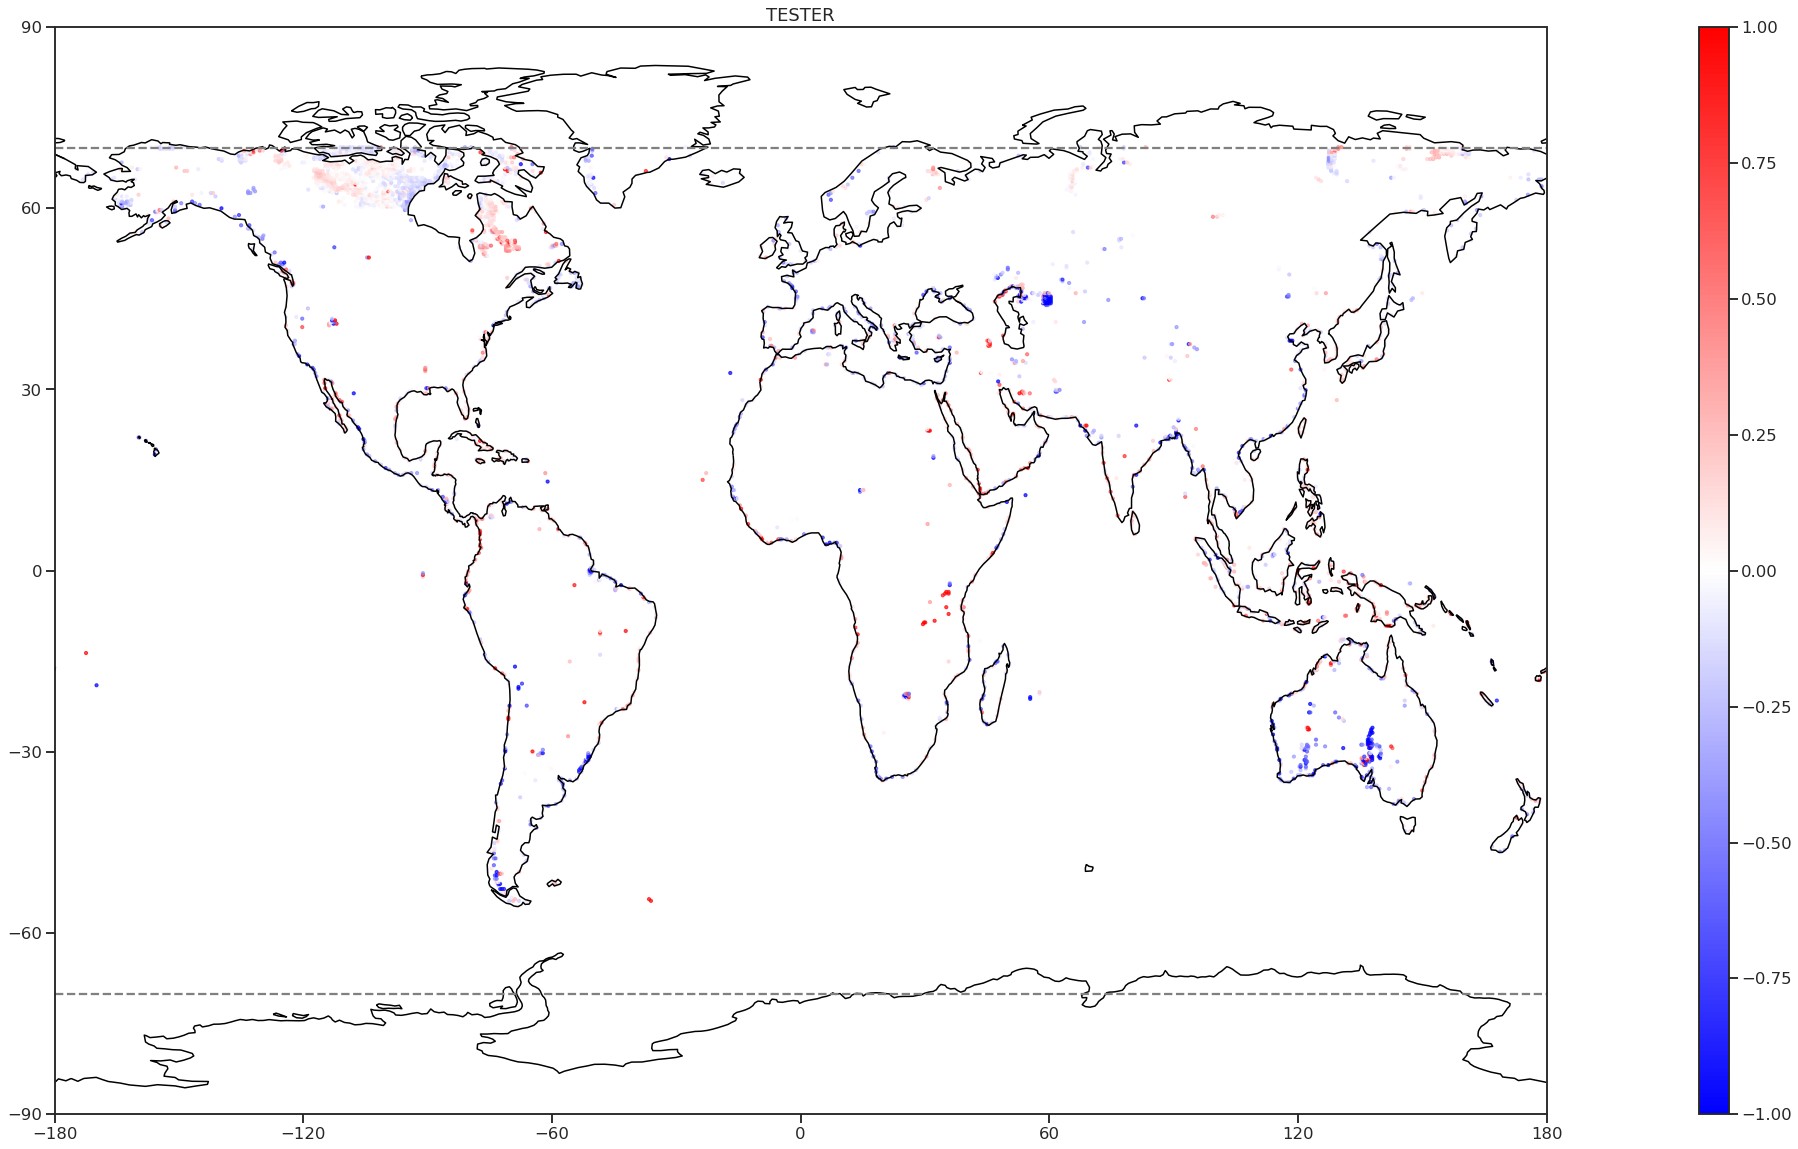

In [41]:




def plot_map_v2(ds,z,vmin,vmax,cmap,logscale,title,limits):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=10,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    





plot_map_v2(df_delta_masked,'compare',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'TESTER',limits=None)
